# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо: Построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

### План работы
- Исследовательский анализ данных
- Обучение модели
- Вывод

### Описание данных
Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`. \
В моём распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


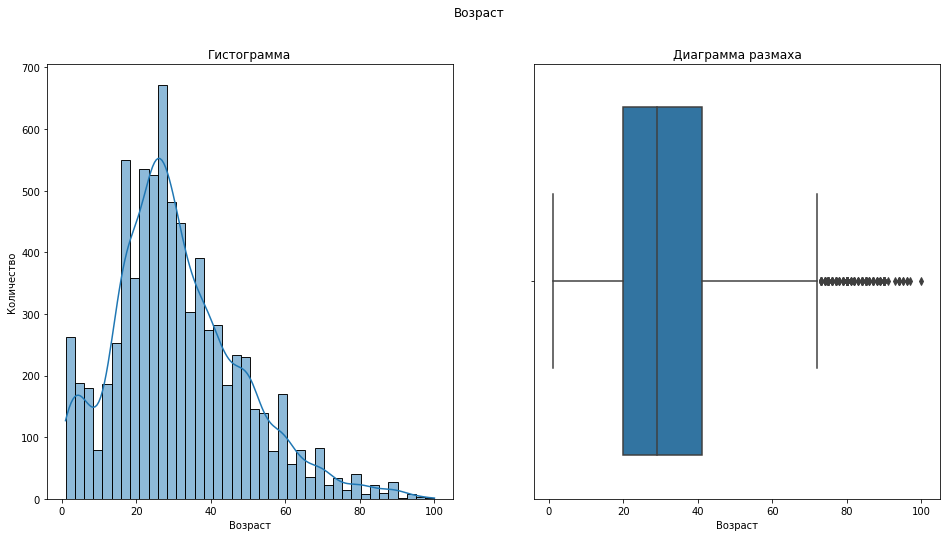

In [5]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sn.histplot(data = data,x = 'real_age', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Возраст')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sn.boxplot(data = data,x = 'real_age', ax=axs[1])
axs[1].set_xlabel('Возраст')
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Возраст')
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


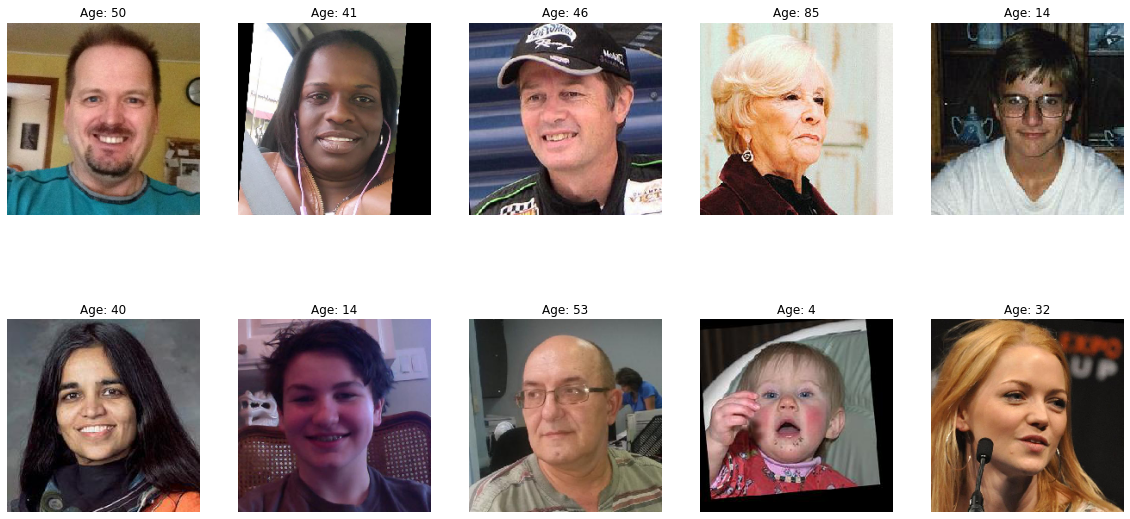

In [7]:
images, labels = next(train_gen_flow)
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}')
    plt.axis('off')

plt.show()

Был проведён исследовательский анализ данных, был изучен и осмотрен датасет, проведено исследование распределение возрастов в выборке и осмотрены фотографии. Некоторые фотографии в неидеальном качестве - либо слишком тёмные, где то слишком отдалены (лицо человека не видно)

Если говорить про распределение возрастов, то оно похоже на распределение, с отклонением вправо. Наибольшее количество людей в выборке от 20 до 40 лет, дальше с ростом возраста, количество людей, соответствующих этому возрасту, уменьшается.

В датасете есть повёрнутые фотографии, и скорее всего они могут влиять на обучение, ведь лицо человека может выглядеть по-разному в зависимости от угла обзора и ориентации. Повернутое изображение может привести к неправильному восприятию ключевых черт, таких как линии подбородка, морщины и другие признаки возраста.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.regularizers import l2

datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
seed = 12345


def load_train(path):
    labels_df = pd.read_csv(f'{path}/labels.csv')

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=seed
    )

    return train_datagen_flow


def load_test(path):
    labels_df = pd.read_csv(f'{path}/labels.csv')

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=seed
    )

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    for layer in backbone.layers[-10:]:
        layer.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model



```

Train for 190 steps, validate for 48 steps\
Epoch 1/8\
190/190 - 57s - loss: 11.2676 - mean_absolute_error: 11.2710 - val_loss: 25.0715 - val_mean_absolute_error: 25.0452\
Epoch 2/8\
190/190 - 46s - loss: 6.9244 - mean_absolute_error: 6.9263 - val_loss: 24.6574 - val_mean_absolute_error: 24.6266\
Epoch 3/8\
190/190 - 46s - loss: 5.5883 - mean_absolute_error: 5.5895 - val_loss: 14.5477 - val_mean_absolute_error: 14.5007\
Epoch 4/8\
190/190 - 46s - loss: 4.7537 - mean_absolute_error: 4.7555 - val_loss: 8.0534 - val_mean_absolute_error: 8.0411\
Epoch 5/8\
190/190 - 47s - loss: 4.3930 - mean_absolute_error: 4.3951 - val_loss: 7.1433 - val_mean_absolute_error: 7.1376\
Epoch 6/8\
190/190 - 47s - loss: 3.9047 - mean_absolute_error: 3.9057 - val_loss: 6.3074 - val_mean_absolute_error: 6.3144\
Epoch 7/8\
190/190 - 46s - loss: 3.5868 - mean_absolute_error: 3.5879 - val_loss: 6.4844 - val_mean_absolute_error: 6.4878\
Epoch 8/8\
190/190 - 46s - loss: 3.2919 - mean_absolute_error: 3.2922 - val_loss: 6.1441 - val_mean_absolute_error: 6.1361\
48/48 - 9s - loss: 6.1441 - mean_absolute_error: 6.1361\
Test MAE: 6.1361

## Анализ обученной модели

Была обучена модель, решающая задачу регрессии - предсказания возвраста по фотографии. Работа модели успешна - метрика MAE 6.13, по условию задачи она должна быть меньше 8.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы